Neural Networks with Python

In [1]:
import pandas as pd
import numpy as np

import sklearn

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.pipeline import Pipeline
from keras.wrappers.scikit_learn import KerasRegressor, KerasClassifier
from sklearn.preprocessing import StandardScaler, QuantileTransformer, MinMaxScaler, RobustScaler

from keras.models import Model
from keras.optimizers import Adam
from keras.layers import TimeDistributed, GlobalAveragePooling1D, Activation, Input, LSTM, GRU, Dense, Dropout, Flatten, Embedding, SpatialDropout1D, Bidirectional, CuDNNGRU
from keras.layers.convolutional import Conv1D, MaxPooling1D, AveragePooling1D
from keras.layers.normalization import BatchNormalization
from keras.layers import Flatten, concatenate
from keras.engine.topology import Layer
from keras import initializers, regularizers, constraints, activations
from keras.layers.recurrent import Recurrent
from keras.engine import InputSpec
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau, CSVLogger

import tensorflow as tf
from tensorflow import set_random_seed
from keras import backend as K

# This part required only for GPU
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.gpu_options.allocator_type = 'BFC'
sess = tf.Session(config=config)
K.set_session(sess)

seed = 10293239

from tensorflow import keras
from tensorflow.keras import layers

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([(

In [2]:
bugs = pd.read_csv('bugs.csv', sep=';', index_col=None)
bugs.head(4)

,CBO,DIT,FanIn,FanOut,LCOM,NOC,RFC,WMC,LOC,Attributes,AttributesInherited,Methods,MethodsInherited,Bugs
0,9,2,1,9,15,0,34,20,122,1,8,6,19,0
1,1,1,1,0,0,0,1,1,4,2,0,1,8,0
2,114,1,102,18,190,6,156,176,484,131,249,20,8,1
3,5,6,1,4,10,0,18,12,33,0,61,5,207,0


In [3]:
bugs.isna().sum()

CBO                     0
DIT                     0
FanIn                   0
FanOut                  0
LCOM                    0
NOC                     0
RFC                     0
WMC                     0
LOC                     0
Attributes              0
AttributesInherited     0
Methods                 0
MethodsInherited        0
Bugs                    0
dtype: int64

In [4]:
y = bugs['Bugs ']
X = bugs.drop(['Bugs '], axis=1, inplace=False)

In [5]:
def get_regression_model(n_features=None):
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[n_features]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [6]:
#For regression
np.random.seed(seed)
set_random_seed(seed)

callbacks_list = [
    EarlyStopping(
        monitor='val_loss',
        patience=10)
]

pipeline = []
pipeline.append(('standard', StandardScaler()))

In [7]:
#For regression
EPOCHS = 1000
pipeline.append(('regressor', KerasRegressor(build_fn=get_regression_model,  
                                        epochs=EPOCHS,
                                        batch_size=128, 
                                        verbose=2, 
                                        callbacks=callbacks_list,
                                        n_features=X.shape[1]))) 

In [8]:
model = Pipeline(pipeline)

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=seed, stratify=y)

In [10]:
model.fit(X_train, y_train)

Epoch 1/1000
 - 0s - loss: 1.3986 - mean_absolute_error: 0.5408 - mean_squared_error: 1.3986
Epoch 2/1000
 - 0s - loss: 0.9157 - mean_absolute_error: 0.4371 - mean_squared_error: 0.9157
Epoch 3/1000
 - 0s - loss: 0.7924 - mean_absolute_error: 0.4567 - mean_squared_error: 0.7924
Epoch 4/1000
 - 0s - loss: 0.7438 - mean_absolute_error: 0.4107 - mean_squared_error: 0.7438
Epoch 5/1000
 - 0s - loss: 0.7242 - mean_absolute_error: 0.4068 - mean_squared_error: 0.7242
Epoch 6/1000
 - 0s - loss: 0.6907 - mean_absolute_error: 0.3984 - mean_squared_error: 0.6907
Epoch 7/1000
 - 0s - loss: 0.6816 - mean_absolute_error: 0.4096 - mean_squared_error: 0.6816
Epoch 8/1000
 - 0s - loss: 0.6571 - mean_absolute_error: 0.3862 - mean_squared_error: 0.6571
Epoch 9/1000
 - 0s - loss: 0.6500 - mean_absolute_error: 0.3893 - mean_squared_error: 0.6500
Epoch 10/1000
 - 0s - loss: 0.6326 - mean_absolute_error: 0.3938 - mean_squared_error: 0.6326
Epoch 11/1000
 - 0s - loss: 0.6283 - mean_absolute_error: 0.3875 - me

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/keras/callbacks/callbacks.py:843: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mean_absolute_error,mean_squared_error
  warnings.warn(


Epoch 33/1000
 - 0s - loss: 0.4376 - mean_absolute_error: 0.3424 - mean_squared_error: 0.4376
Epoch 34/1000
 - 0s - loss: 0.4400 - mean_absolute_error: 0.3367 - mean_squared_error: 0.4400
Epoch 35/1000
 - 0s - loss: 0.4196 - mean_absolute_error: 0.3279 - mean_squared_error: 0.4196
Epoch 36/1000
 - 0s - loss: 0.4197 - mean_absolute_error: 0.3358 - mean_squared_error: 0.4197
Epoch 37/1000
 - 0s - loss: 0.4140 - mean_absolute_error: 0.3416 - mean_squared_error: 0.4140
Epoch 38/1000
 - 0s - loss: 0.4074 - mean_absolute_error: 0.3190 - mean_squared_error: 0.4074
Epoch 39/1000
 - 0s - loss: 0.4061 - mean_absolute_error: 0.3279 - mean_squared_error: 0.4061
Epoch 40/1000
 - 0s - loss: 0.3984 - mean_absolute_error: 0.3264 - mean_squared_error: 0.3984
Epoch 41/1000
 - 0s - loss: 0.4005 - mean_absolute_error: 0.3238 - mean_squared_error: 0.4005
Epoch 42/1000
 - 0s - loss: 0.3950 - mean_absolute_error: 0.3219 - mean_squared_error: 0.3950
Epoch 43/1000
 - 0s - loss: 0.3884 - mean_absolute_error: 0.

Epoch 120/1000
 - 0s - loss: 0.1923 - mean_absolute_error: 0.2435 - mean_squared_error: 0.1923
Epoch 121/1000
 - 0s - loss: 0.1940 - mean_absolute_error: 0.2447 - mean_squared_error: 0.1940
Epoch 122/1000
 - 0s - loss: 0.1898 - mean_absolute_error: 0.2465 - mean_squared_error: 0.1898
Epoch 123/1000
 - 0s - loss: 0.1969 - mean_absolute_error: 0.2573 - mean_squared_error: 0.1969
Epoch 124/1000
 - 0s - loss: 0.2099 - mean_absolute_error: 0.2558 - mean_squared_error: 0.2099
Epoch 125/1000
 - 0s - loss: 0.1841 - mean_absolute_error: 0.2384 - mean_squared_error: 0.1841
Epoch 126/1000
 - 0s - loss: 0.1943 - mean_absolute_error: 0.2486 - mean_squared_error: 0.1943
Epoch 127/1000
 - 0s - loss: 0.1893 - mean_absolute_error: 0.2423 - mean_squared_error: 0.1893
Epoch 128/1000
 - 0s - loss: 0.1887 - mean_absolute_error: 0.2537 - mean_squared_error: 0.1887
Epoch 129/1000
 - 0s - loss: 0.1800 - mean_absolute_error: 0.2492 - mean_squared_error: 0.1800
Epoch 130/1000
 - 0s - loss: 0.1828 - mean_absolut

Epoch 207/1000
 - 0s - loss: 0.1193 - mean_absolute_error: 0.2147 - mean_squared_error: 0.1193
Epoch 208/1000
 - 0s - loss: 0.1096 - mean_absolute_error: 0.2005 - mean_squared_error: 0.1096
Epoch 209/1000
 - 0s - loss: 0.1325 - mean_absolute_error: 0.2274 - mean_squared_error: 0.1325
Epoch 210/1000
 - 0s - loss: 0.1297 - mean_absolute_error: 0.2210 - mean_squared_error: 0.1297
Epoch 211/1000
 - 0s - loss: 0.1064 - mean_absolute_error: 0.1906 - mean_squared_error: 0.1064
Epoch 212/1000
 - 0s - loss: 0.1103 - mean_absolute_error: 0.2036 - mean_squared_error: 0.1103
Epoch 213/1000
 - 0s - loss: 0.1232 - mean_absolute_error: 0.2221 - mean_squared_error: 0.1232
Epoch 214/1000
 - 0s - loss: 0.1222 - mean_absolute_error: 0.2146 - mean_squared_error: 0.1222
Epoch 215/1000
 - 0s - loss: 0.1102 - mean_absolute_error: 0.2010 - mean_squared_error: 0.1102
Epoch 216/1000
 - 0s - loss: 0.1063 - mean_absolute_error: 0.2006 - mean_squared_error: 0.1063
Epoch 217/1000
 - 0s - loss: 0.1188 - mean_absolut

Epoch 294/1000
 - 0s - loss: 0.1039 - mean_absolute_error: 0.1940 - mean_squared_error: 0.1039
Epoch 295/1000
 - 0s - loss: 0.0839 - mean_absolute_error: 0.1899 - mean_squared_error: 0.0839
Epoch 296/1000
 - 0s - loss: 0.0794 - mean_absolute_error: 0.1829 - mean_squared_error: 0.0794
Epoch 297/1000
 - 0s - loss: 0.0870 - mean_absolute_error: 0.1917 - mean_squared_error: 0.0870
Epoch 298/1000
 - 0s - loss: 0.0805 - mean_absolute_error: 0.1839 - mean_squared_error: 0.0805
Epoch 299/1000
 - 0s - loss: 0.0826 - mean_absolute_error: 0.1903 - mean_squared_error: 0.0826
Epoch 300/1000
 - 0s - loss: 0.0780 - mean_absolute_error: 0.1783 - mean_squared_error: 0.0780
Epoch 301/1000
 - 0s - loss: 0.1052 - mean_absolute_error: 0.2080 - mean_squared_error: 0.1052
Epoch 302/1000
 - 0s - loss: 0.0893 - mean_absolute_error: 0.1925 - mean_squared_error: 0.0893
Epoch 303/1000
 - 0s - loss: 0.0885 - mean_absolute_error: 0.1796 - mean_squared_error: 0.0885
Epoch 304/1000
 - 0s - loss: 0.0955 - mean_absolut

Epoch 381/1000
 - 0s - loss: 0.0676 - mean_absolute_error: 0.1725 - mean_squared_error: 0.0676
Epoch 382/1000
 - 0s - loss: 0.0605 - mean_absolute_error: 0.1554 - mean_squared_error: 0.0605
Epoch 383/1000
 - 0s - loss: 0.0911 - mean_absolute_error: 0.2124 - mean_squared_error: 0.0911
Epoch 384/1000
 - 0s - loss: 0.0648 - mean_absolute_error: 0.1615 - mean_squared_error: 0.0648
Epoch 385/1000
 - 0s - loss: 0.0612 - mean_absolute_error: 0.1550 - mean_squared_error: 0.0612
Epoch 386/1000
 - 0s - loss: 0.0727 - mean_absolute_error: 0.1786 - mean_squared_error: 0.0727
Epoch 387/1000
 - 0s - loss: 0.0834 - mean_absolute_error: 0.1955 - mean_squared_error: 0.0834
Epoch 388/1000
 - 0s - loss: 0.0648 - mean_absolute_error: 0.1647 - mean_squared_error: 0.0648
Epoch 389/1000
 - 0s - loss: 0.0695 - mean_absolute_error: 0.1717 - mean_squared_error: 0.0695
Epoch 390/1000
 - 0s - loss: 0.0814 - mean_absolute_error: 0.1877 - mean_squared_error: 0.0814
Epoch 391/1000
 - 0s - loss: 0.0758 - mean_absolut

Epoch 468/1000
 - 0s - loss: 0.0504 - mean_absolute_error: 0.1381 - mean_squared_error: 0.0504
Epoch 469/1000
 - 0s - loss: 0.0572 - mean_absolute_error: 0.1587 - mean_squared_error: 0.0572
Epoch 470/1000
 - 0s - loss: 0.0584 - mean_absolute_error: 0.1661 - mean_squared_error: 0.0584
Epoch 471/1000
 - 0s - loss: 0.0533 - mean_absolute_error: 0.1426 - mean_squared_error: 0.0533
Epoch 472/1000
 - 0s - loss: 0.0626 - mean_absolute_error: 0.1631 - mean_squared_error: 0.0626
Epoch 473/1000
 - 0s - loss: 0.0742 - mean_absolute_error: 0.1845 - mean_squared_error: 0.0742
Epoch 474/1000
 - 0s - loss: 0.0656 - mean_absolute_error: 0.1647 - mean_squared_error: 0.0656
Epoch 475/1000
 - 0s - loss: 0.0488 - mean_absolute_error: 0.1343 - mean_squared_error: 0.0488
Epoch 476/1000
 - 0s - loss: 0.0626 - mean_absolute_error: 0.1713 - mean_squared_error: 0.0626
Epoch 477/1000
 - 0s - loss: 0.0836 - mean_absolute_error: 0.1843 - mean_squared_error: 0.0836
Epoch 478/1000
 - 0s - loss: 0.0529 - mean_absolut

Epoch 555/1000
 - 0s - loss: 0.0660 - mean_absolute_error: 0.1826 - mean_squared_error: 0.0660
Epoch 556/1000
 - 0s - loss: 0.0651 - mean_absolute_error: 0.1662 - mean_squared_error: 0.0651
Epoch 557/1000
 - 0s - loss: 0.0546 - mean_absolute_error: 0.1478 - mean_squared_error: 0.0546
Epoch 558/1000
 - 0s - loss: 0.0484 - mean_absolute_error: 0.1352 - mean_squared_error: 0.0484
Epoch 559/1000
 - 0s - loss: 0.0703 - mean_absolute_error: 0.1757 - mean_squared_error: 0.0703
Epoch 560/1000
 - 0s - loss: 0.0745 - mean_absolute_error: 0.1759 - mean_squared_error: 0.0745
Epoch 561/1000
 - 0s - loss: 0.0506 - mean_absolute_error: 0.1381 - mean_squared_error: 0.0506
Epoch 562/1000
 - 0s - loss: 0.0529 - mean_absolute_error: 0.1548 - mean_squared_error: 0.0529
Epoch 563/1000
 - 0s - loss: 0.0529 - mean_absolute_error: 0.1536 - mean_squared_error: 0.0529
Epoch 564/1000
 - 0s - loss: 0.0518 - mean_absolute_error: 0.1440 - mean_squared_error: 0.0518
Epoch 565/1000
 - 0s - loss: 0.0650 - mean_absolut

Epoch 642/1000
 - 0s - loss: 0.0437 - mean_absolute_error: 0.1335 - mean_squared_error: 0.0437
Epoch 643/1000
 - 0s - loss: 0.0825 - mean_absolute_error: 0.1789 - mean_squared_error: 0.0825
Epoch 644/1000
 - 0s - loss: 0.0624 - mean_absolute_error: 0.1552 - mean_squared_error: 0.0624
Epoch 645/1000
 - 0s - loss: 0.0434 - mean_absolute_error: 0.1292 - mean_squared_error: 0.0434
Epoch 646/1000
 - 0s - loss: 0.0461 - mean_absolute_error: 0.1419 - mean_squared_error: 0.0461
Epoch 647/1000
 - 0s - loss: 0.0552 - mean_absolute_error: 0.1533 - mean_squared_error: 0.0552
Epoch 648/1000
 - 0s - loss: 0.0669 - mean_absolute_error: 0.1594 - mean_squared_error: 0.0669
Epoch 649/1000
 - 0s - loss: 0.0492 - mean_absolute_error: 0.1468 - mean_squared_error: 0.0492
Epoch 650/1000
 - 0s - loss: 0.0464 - mean_absolute_error: 0.1339 - mean_squared_error: 0.0464
Epoch 651/1000
 - 0s - loss: 0.0471 - mean_absolute_error: 0.1442 - mean_squared_error: 0.0471
Epoch 652/1000
 - 0s - loss: 0.0463 - mean_absolut

Epoch 729/1000
 - 0s - loss: 0.0381 - mean_absolute_error: 0.1191 - mean_squared_error: 0.0381
Epoch 730/1000
 - 0s - loss: 0.0692 - mean_absolute_error: 0.1753 - mean_squared_error: 0.0692
Epoch 731/1000
 - 0s - loss: 0.0543 - mean_absolute_error: 0.1500 - mean_squared_error: 0.0543
Epoch 732/1000
 - 0s - loss: 0.0506 - mean_absolute_error: 0.1454 - mean_squared_error: 0.0506
Epoch 733/1000
 - 0s - loss: 0.0413 - mean_absolute_error: 0.1269 - mean_squared_error: 0.0413
Epoch 734/1000
 - 0s - loss: 0.0466 - mean_absolute_error: 0.1445 - mean_squared_error: 0.0466
Epoch 735/1000
 - 0s - loss: 0.0605 - mean_absolute_error: 0.1622 - mean_squared_error: 0.0605
Epoch 736/1000
 - 0s - loss: 0.0439 - mean_absolute_error: 0.1253 - mean_squared_error: 0.0439
Epoch 737/1000
 - 0s - loss: 0.0417 - mean_absolute_error: 0.1306 - mean_squared_error: 0.0417
Epoch 738/1000
 - 0s - loss: 0.0538 - mean_absolute_error: 0.1643 - mean_squared_error: 0.0538
Epoch 739/1000
 - 0s - loss: 0.0450 - mean_absolut

Epoch 816/1000
 - 0s - loss: 0.0637 - mean_absolute_error: 0.1519 - mean_squared_error: 0.0637
Epoch 817/1000
 - 0s - loss: 0.0421 - mean_absolute_error: 0.1247 - mean_squared_error: 0.0421
Epoch 818/1000
 - 0s - loss: 0.0451 - mean_absolute_error: 0.1409 - mean_squared_error: 0.0451
Epoch 819/1000
 - 0s - loss: 0.0429 - mean_absolute_error: 0.1350 - mean_squared_error: 0.0429
Epoch 820/1000
 - 0s - loss: 0.0385 - mean_absolute_error: 0.1232 - mean_squared_error: 0.0385
Epoch 821/1000
 - 0s - loss: 0.0484 - mean_absolute_error: 0.1480 - mean_squared_error: 0.0484
Epoch 822/1000
 - 0s - loss: 0.0417 - mean_absolute_error: 0.1232 - mean_squared_error: 0.0417
Epoch 823/1000
 - 0s - loss: 0.0474 - mean_absolute_error: 0.1352 - mean_squared_error: 0.0474
Epoch 824/1000
 - 0s - loss: 0.0429 - mean_absolute_error: 0.1374 - mean_squared_error: 0.0429
Epoch 825/1000
 - 0s - loss: 0.0547 - mean_absolute_error: 0.1470 - mean_squared_error: 0.0547
Epoch 826/1000
 - 0s - loss: 0.0382 - mean_absolut

Epoch 903/1000
 - 0s - loss: 0.0357 - mean_absolute_error: 0.1170 - mean_squared_error: 0.0357
Epoch 904/1000
 - 0s - loss: 0.0399 - mean_absolute_error: 0.1364 - mean_squared_error: 0.0399
Epoch 905/1000
 - 0s - loss: 0.0554 - mean_absolute_error: 0.1603 - mean_squared_error: 0.0554
Epoch 906/1000
 - 0s - loss: 0.0395 - mean_absolute_error: 0.1239 - mean_squared_error: 0.0395
Epoch 907/1000
 - 0s - loss: 0.0350 - mean_absolute_error: 0.1180 - mean_squared_error: 0.0350
Epoch 908/1000
 - 0s - loss: 0.0431 - mean_absolute_error: 0.1309 - mean_squared_error: 0.0431
Epoch 909/1000
 - 0s - loss: 0.0493 - mean_absolute_error: 0.1538 - mean_squared_error: 0.0493
Epoch 910/1000
 - 0s - loss: 0.0393 - mean_absolute_error: 0.1306 - mean_squared_error: 0.0393
Epoch 911/1000
 - 0s - loss: 0.0416 - mean_absolute_error: 0.1312 - mean_squared_error: 0.0416
Epoch 912/1000
 - 0s - loss: 0.0379 - mean_absolute_error: 0.1193 - mean_squared_error: 0.0379
Epoch 913/1000
 - 0s - loss: 0.0464 - mean_absolut

Epoch 990/1000
 - 0s - loss: 0.0431 - mean_absolute_error: 0.1362 - mean_squared_error: 0.0431
Epoch 991/1000
 - 0s - loss: 0.0335 - mean_absolute_error: 0.1124 - mean_squared_error: 0.0335
Epoch 992/1000
 - 0s - loss: 0.0410 - mean_absolute_error: 0.1230 - mean_squared_error: 0.0410
Epoch 993/1000
 - 0s - loss: 0.0547 - mean_absolute_error: 0.1659 - mean_squared_error: 0.0547
Epoch 994/1000
 - 0s - loss: 0.0360 - mean_absolute_error: 0.1158 - mean_squared_error: 0.0360
Epoch 995/1000
 - 0s - loss: 0.0318 - mean_absolute_error: 0.1090 - mean_squared_error: 0.0318
Epoch 996/1000
 - 0s - loss: 0.0468 - mean_absolute_error: 0.1450 - mean_squared_error: 0.0468
Epoch 997/1000
 - 0s - loss: 0.0383 - mean_absolute_error: 0.1327 - mean_squared_error: 0.0383
Epoch 998/1000
 - 0s - loss: 0.0473 - mean_absolute_error: 0.1406 - mean_squared_error: 0.0473
Epoch 999/1000
 - 0s - loss: 0.0427 - mean_absolute_error: 0.1333 - mean_squared_error: 0.0427
Epoch 1000/1000
 - 0s - loss: 0.0347 - mean_absolu

Pipeline(memory=None,
         steps=[('standard',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('regressor',
                 <keras.wrappers.scikit_learn.KerasRegressor object at 0x136e817c0>)],
         verbose=False)

In [11]:
example_batch = X_train[:1000]
example_result = model.predict(example_batch)
example_result

TypeError: predict() got an unexpected keyword argument 'callbacks'

In [12]:
y_pred = model.predict(X_test)

TypeError: predict() got an unexpected keyword argument 'callbacks'

In [13]:
#For regression
from sklearn.metrics import explained_variance_score, max_error, mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score

variance = explained_variance_score(y_test, y_pred)
max_error = max_error(y_test, y_pred)
mean_absolute_error = mean_absolute_error(y_test, y_pred)
mean_squared_error = mean_squared_error(y_test, y_pred)
#mean_squared_log_error = mean_squared_log_error(y_test, y_pred)
median_absolute_error = median_absolute_error(y_test, y_pred)
r2_score = r2_score(y_test, y_pred)

"Variance = {:.3f}, Max Error = {:.3f}, Mean Absolute Error = {:.3f}, Mean Squared Error = {:.3f}, Median Absolute Error = {:.3f}, R2 = {:.3f}".format(variance, max_error, mean_absolute_error, mean_squared_error, median_absolute_error, r2_score)


NameError: name 'y_pred' is not defined

NameError: name 'y_pred' is not defined

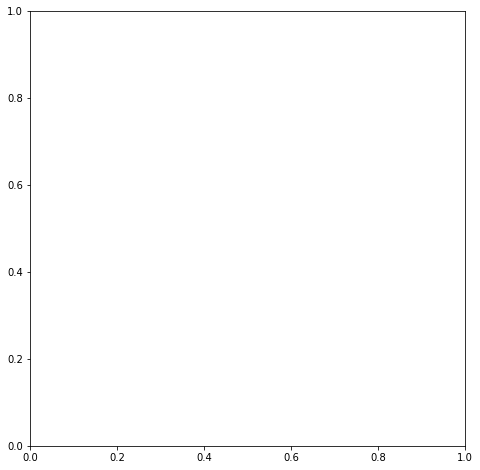

In [14]:
#For regression
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [Bugs]')
plt.ylabel('Predictions [Bugs]')
lims = [0, 10]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

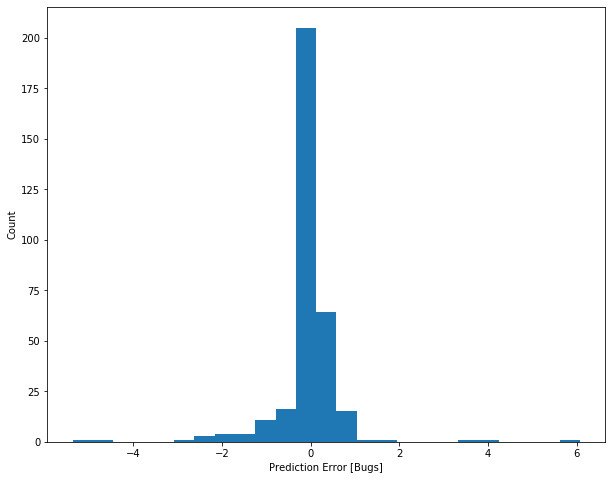

In [15]:
error = y_pred - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [Bugs]")
_ = plt.ylabel("Count")